In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 13.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image, ImageFont
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.utils import to_categorical, plot_model
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16, ResNet50
import visualkeras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
folder_path = r"/content/drive/MyDrive/UploadedFolder"

def load_and_resize_images(folder_path, target_size=(50, 50)):
    """Loads images from the specified folder, resizes them, and extracts labels."""
    resized_images, labels = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            resized_images.append(cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC))
            labels.append(int(filename.split('_')[0]))  # Extract label from filename
    return resized_images, labels


def describe_data(images, labels):
    """Prints descriptive statistics about the image data."""
    print('Total number of images:', len(images))
    print('IDC(-) Images:', labels.count(0))
    print('IDC(+) Images:', labels.count(1))
    print('Image shape (Width, Height, Channels):', images[0].shape)

resized_images, labels_arr = load_and_resize_images(folder_path)
describe_data(resized_images, labels_arr)

Total number of images: 20000
IDC(-) Images: 13351
IDC(+) Images: 6649
Image shape (Width, Height, Channels): (50, 50, 3)


In [ ]:
def prepare_and_flatten_data(resized_images, labels_arr):
    """Prepares the data, performs train-test split, and flattens the images."""
    X = np.array(resized_images)
    Y = pd.Series(labels_arr)
    X = X / 255.0  # Normalize pixel values

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    print("Training Data Shape:", X_train.shape)
    print("Testing Data Shape:", X_test.shape)

    # Make Data 1D for compatibility with upsampling methods
    image_shape = 50 * 50 * 3
    X_train = X_train.reshape(X_train.shape[0], image_shape)
    X_test = X_test.reshape(X_test.shape[0], image_shape)
    print("Shape of flattened training data:", X_train.shape)
    print("Shape of flattened testing data:", X_test.shape)

    return X_train, X_test, Y_train, Y_test


# Prepare and flatten the data
X_train, X_test, Y_train, Y_test = prepare_and_flatten_data(resized_images, labels_arr)


Training Data Shape: (16000, 50, 50, 3)
Testing Data Shape: (4000, 50, 50, 3)
Shape of flattened training data: (16000, 7500)
Shape of flattened testing data: (4000, 7500)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from sklearn.utils.validation import _check_n_features, _check_feature_names


def handle_class_imbalance(X_train, Y_train, X_test, Y_test):
    """Handles class imbalance using RandomUnderSampler and reshapes data."""
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

    X_train_rus_flat, Y_train_rus = rus.fit_resample(X_train, Y_train)
    X_test_rus_flat, Y_test_rus = rus.fit_resample(X_test, Y_test)

    # Reshape the images
    X_train_rus = X_train_rus_flat.reshape(len(X_train_rus_flat), 50, 50, 3)
    X_test_rus = X_test_rus_flat.reshape(len(X_test_rus_flat), 50, 50, 3)

    # Encode labels
    Y_train_rus = to_categorical(Y_train_rus, num_classes=2)
    Y_test_rus = to_categorical(Y_test_rus, num_classes=2)

    print("New shape of Train data =", X_train_rus.shape)
    print("New shape of Test data =", X_test_rus.shape)

    return X_train_rus, Y_train_rus, X_test_rus, Y_test_rus


# Handle class imbalance
X_train_rus, Y_train_rus, X_test_rus, Y_test_rus = handle_class_imbalance(X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and w

New shape of Train data = (10618, 50, 50, 3)
New shape of Test data = (2680, 50, 50, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

def define_metrics_checkpoint(savepath='logs.npy'):
    """Defines the MetricsCheckpoint callback to save metrics after each epoch."""
    class MetricsCheckpoint(Callback):
        def __init__(self, savepath):
            super(MetricsCheckpoint, self).__init__()
            self.savepath = savepath
            self.history = {}

        def on_epoch_end(self, epoch, logs=None):
            for k, v in logs.items():
                self.history.setdefault(k, []).append(v)
            np.save(self.savepath, self.history)
    return MetricsCheckpoint(savepath)

def plot_learning_curve_old(filepath='logs.npy'):
    """Plots the learning curve from saved metrics (old version)."""
    plt.figure(figsize=(10, 6))
    metrics = np.load(filepath, allow_pickle=True).item()  # Use .item() for dictionary
    filt = ['acc']  # try to add 'loss' to see the loss learning curve

    for k in filter(lambda x: np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c='r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x, y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x, y), size='15', color='r' if 'val' not in k else 'b')

    plt.legend(loc=4)
    plt.axis([0, None, None, None])
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.show()

def plot_learning_curve(history):
    """Plots learning curves for accuracy and loss."""
    plt.figure(figsize=(10, 6))

    # Model accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Model loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_confusion_matrix(cm, normalize=False, cmap=plt.cm.Blues):
    title='Confusion matrix'
    classes = {0: 'IDC(-)', 1: 'IDC(+)'}
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

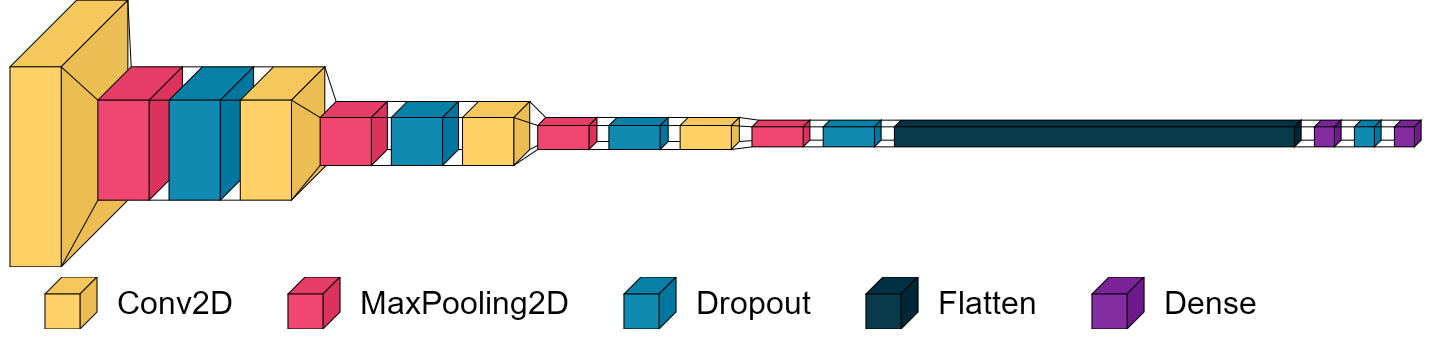

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 25, 25, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 25, 25, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 512)    │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 512)    │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 512)      │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,085,122 (4.14 MB)

 Trainable params: 1,085,122 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def create_cnn_model(num_classes=2, input_shape=(50, 50, 3)):
    """Creates a Convolutional Neural Network (CNN) model."""
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(512, (1, 1), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='sigmoid'))

    font = ImageFont.truetype("arial.ttf", 32)  # Load a custom font (if needed)
    visualkeras.layered_view(model, legend=True, spacing=20, font=font) # Remove to_file to avoid saving

    # Display the model visualization in the output
    display(visualkeras.layered_view(model, legend=True, spacing=20, font=font))
    model.summary()
    return model

model = create_cnn_model()

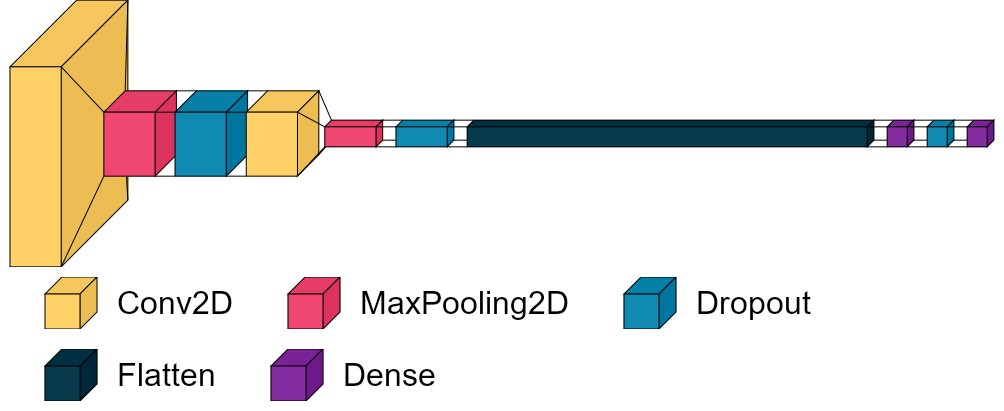

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_layer_1 (Conv2D)           │ (None, 50, 50, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 16, 16, 512)    │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,903,490 (7.26 MB)

 Trainable params: 1,903,490 (7.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

def create_final_cnn_model(num_classes=2, input_shape=(50, 50, 3)):
    """Creates the final Convolutional Neural Network (CNN) model."""
    model = Sequential()
    model.add(Input(shape=input_shape, name='input_layer'))  # Use Input layer for input shape
    model.add(Conv2D(512, (1, 1), activation='relu', name='conv_layer_1'))
    model.add(MaxPooling2D(pool_size=(3, 3), name='max_pooling_1'))
    model.add(Dropout(0.2, name='dropout_1'))

    model.add(Conv2D(512, (1, 1), activation='relu', name='conv_layer_2'))
    model.add(MaxPooling2D(pool_size=(3, 3), name='max_pooling_2'))
    model.add(Dropout(0.2, name='dropout_2'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(128, activation='relu', name='dense_layer',trainable=True))
    model.add(Dropout(0.2, name='dropout_3'))
    model.add(Dense(num_classes, activation='sigmoid', name='output_layer'))  # Output layer
    font = ImageFont.truetype("arial.ttf", 32)  # Load a custom font (if needed)
    visualkeras.layered_view(model, legend=True, spacing=20, font=font) # Remove to_file to avoid saving

    # Display the model visualization in the output
    display(visualkeras.layered_view(model, legend=True, spacing=20, font=font))
    model.summary()
    return model

final_cnn_model = create_final_cnn_model()

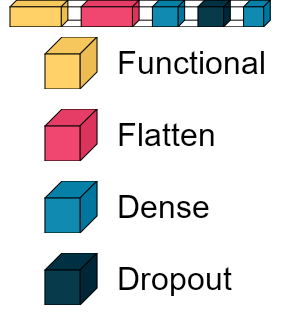

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
def create_vgg16_model(num_classes=2, input_shape=(50, 50, 3)):
    """Creates a VGG16 model."""
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers
    for layer in vgg_model.layers:
        layer.trainable = False

    # Create a new model on top of VGG16
    model = Sequential()
    model.add(vgg_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    font = ImageFont.truetype("arial.ttf", 32)  # Load a custom font (if needed)
    visualkeras.layered_view(model, legend=True, spacing=20, font=font) # Remove to_file to avoid saving

    # Display the model visualization in the output
    display(visualkeras.layered_view(model, legend=True, spacing=20, font=font))
    model.summary()
    return model

# Example usage:
vgg16_model = create_vgg16_model()



#Now you can train the model:
# history = vgg16_model.fit(X_train_rus, Y_train_rus, epochs=10, batch_size=32, validation_data=(X_test_rus, Y_test_rus))
#plot_learning_curve(history)

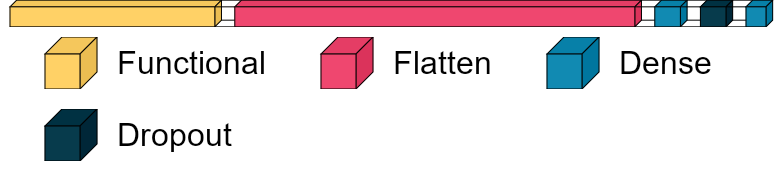

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,685,634 (97.98 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# prompt: same like above can you build resetnet50 model

def create_resnet50_model(num_classes=2, input_shape=(50, 50, 3)):
    """Creates a ResNet50 model."""
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers
    for layer in resnet_model.layers:
        layer.trainable = False

    # Create a new model on top of ResNet50
    model = Sequential()
    model.add(resnet_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    font = ImageFont.truetype("arial.ttf", 32)  # Load a custom font (if needed)
    visualkeras.layered_view(model, legend=True, spacing=20, font=font) # Remove to_file to avoid saving

    # Display the model visualization in the output
    display(visualkeras.layered_view(model, legend=True, spacing=20, font=font))
    model.summary()
    return model

# Example usage:
resnet50_model = create_resnet50_model()

Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.6042 - loss: 0.6485 - val_accuracy: 0.8011 - val_loss: 0.4641
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8013 - loss: 0.4595 - val_accuracy: 0.8116 - val_loss: 0.4244
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8075 - loss: 0.4455 - val_accuracy: 0.8123 - val_loss: 0.4362
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8005 - loss: 0.4419 - val_accuracy: 0.8116 - val_loss: 0.4242
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8023 - loss: 0.4349 - val_accuracy: 0.8168 - val_loss: 0.4177
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8180 - loss: 0.4188 - val_accuracy: 0.8216 - val_loss: 0.4063
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8102 - loss: 0.4140 - val_accuracy: 0.8276 - val_loss: 0.3942
Epoch 8/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8250 - loss: 0.4048 - va

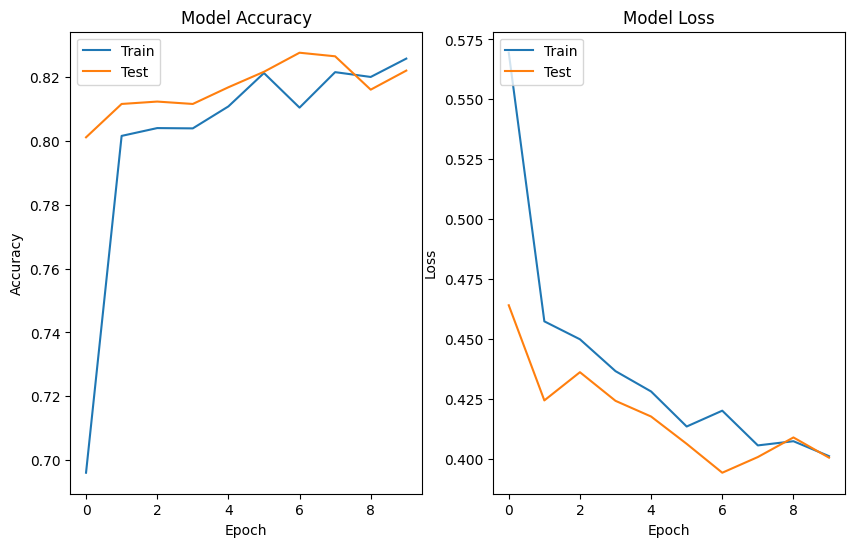

In [ ]:
# Train the final_cnn_model
final_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compile the model before training
history_final_cnn = final_cnn_model.fit(X_train_rus, Y_train_rus, epochs=10, batch_size=32, validation_data=(X_test_rus, Y_test_rus))
plot_learning_curve(history_final_cnn)

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


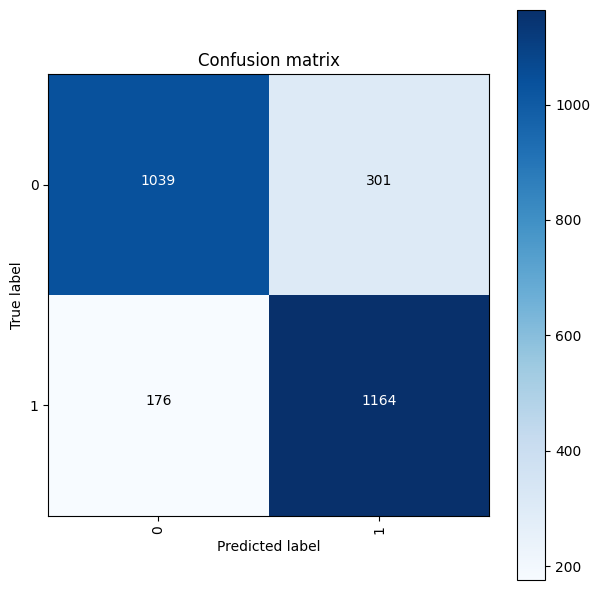

In [ ]:
# prompt: call confusion matrix

Y_pred = final_cnn_model.predict(X_test_rus)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test_rus, axis=1)
cm = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(cm)

Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.6763 - loss: 0.6249 - val_accuracy: 0.7757 - val_loss: 0.4909
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7580 - loss: 0.5012 - val_accuracy: 0.7761 - val_loss: 0.4877
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7701 - loss: 0.4931 - val_accuracy: 0.7825 - val_loss: 0.4709
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7745 - loss: 0.4769 - val_accuracy: 0.7821 - val_loss: 0.4719
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7778 - loss: 0.4658 - val_accuracy: 0.7765 - val_loss: 0.4754
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7846 - loss: 0.4659 - val_accuracy: 0.7828 - val_loss: 0.4669
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7938 - loss: 0.4485 - val_accuracy: 0.7843 - val_loss: 0.4612
Epoch 8/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7880 - loss: 0.4552 - val_

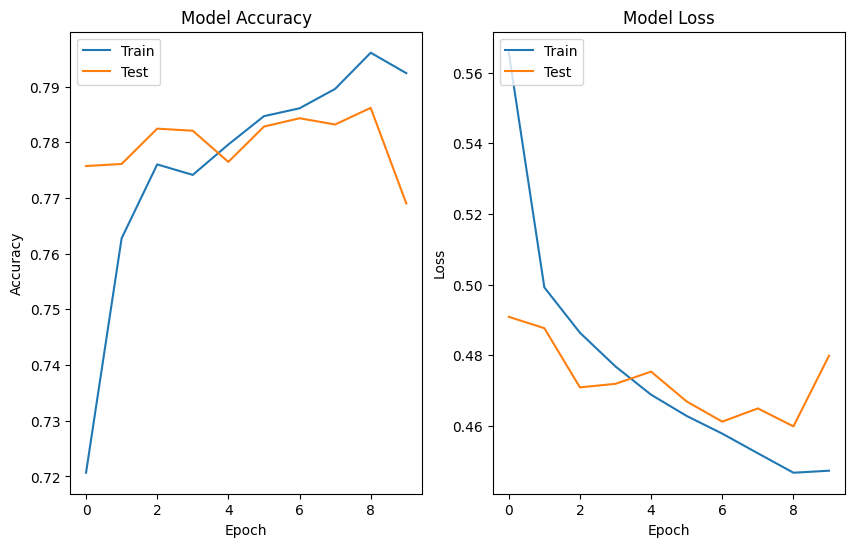

In [ ]:
# Train the vgg16_model
history_vgg16 = vgg16_model.fit(X_train_rus, Y_train_rus, epochs=10, batch_size=32, validation_data=(X_test_rus, Y_test_rus))
plot_learning_curve(history_vgg16)

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


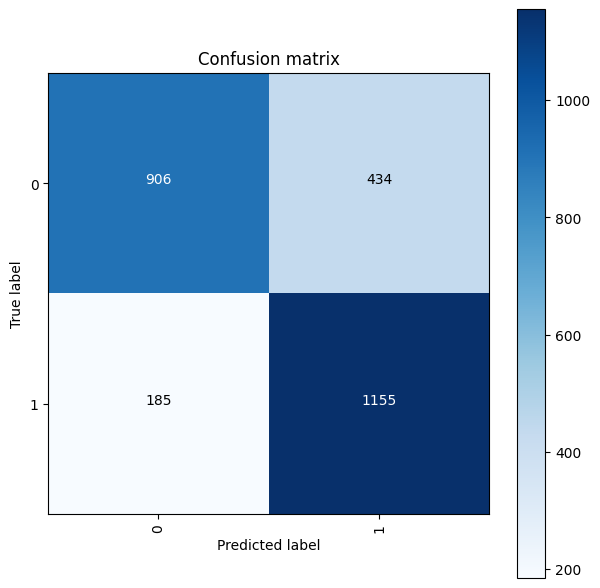

In [ ]:
# prompt: call confusion matrix

Y_pred_vgg = vgg16_model.predict(X_test_rus)
Y_pred_vgg_classes = np.argmax(Y_pred_vgg, axis=1)
Y_true_vgg = np.argmax(Y_test_rus, axis=1)
cm_vgg = confusion_matrix(Y_true_vgg, Y_pred_vgg_classes)
plot_confusion_matrix(cm_vgg)

Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.5196 - loss: 0.7829 - val_accuracy: 0.6616 - val_loss: 0.6684
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.5906 - loss: 0.6688 - val_accuracy: 0.6575 - val_loss: 0.6622
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5900 - loss: 0.6629 - val_accuracy: 0.7093 - val_loss: 0.6357
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6018 - loss: 0.6555 - val_accuracy: 0.7041 - val_loss: 0.6140
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6172 - loss: 0.6418 - val_accuracy: 0.7160 - val_loss: 0.6096
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6267 - loss: 0.6408 - val_accuracy: 0.6765 - val_loss: 0.6292
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6319 - loss: 0.6281 - val_accuracy: 0.6858 - val_loss: 0.6115
Epoch 8/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6070 - loss: 0.6392 - va

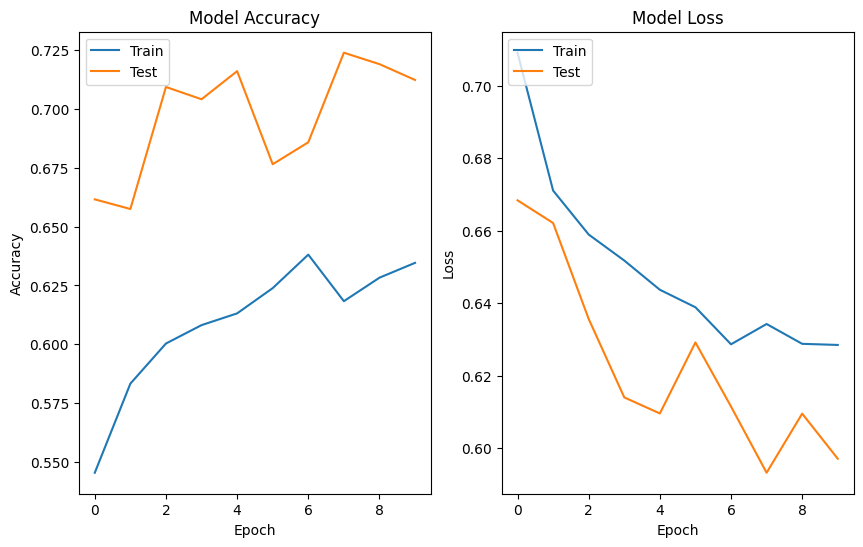

In [ ]:
# Train the resnet50_model
history_resnet50 = resnet50_model.fit(X_train_rus, Y_train_rus, epochs=10, batch_size=32, validation_data=(X_test_rus, Y_test_rus))
plot_learning_curve(history_resnet50)

84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step


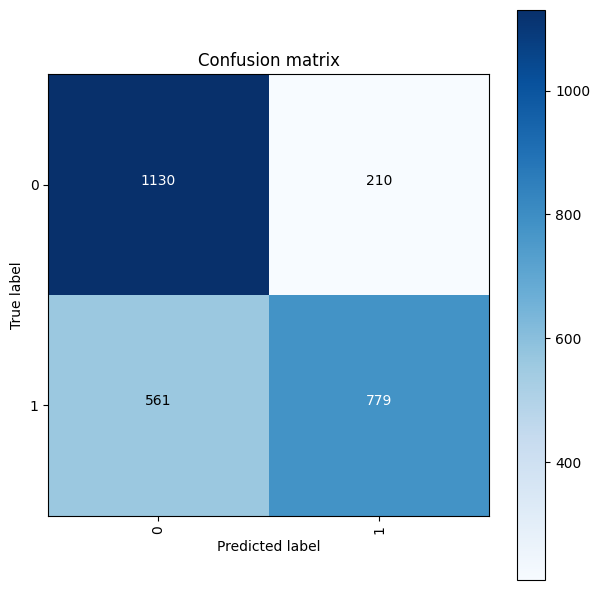

In [ ]:
# prompt: call confusion matrix

Y_pred_resnet = resnet50_model.predict(X_test_rus)
Y_pred_resnet_classes = np.argmax(Y_pred_resnet, axis=1)
Y_true_resnet = np.argmax(Y_test_rus, axis=1)
cm_resnet = confusion_matrix(Y_true_resnet, Y_pred_resnet_classes)
plot_confusion_matrix(cm_resnet)

In [ ]:
# Evaluate the models and print classification reports
from sklearn.metrics import classification_report

# Evaluate the final_cnn_model
Y_pred_cnn = final_cnn_model.predict(X_test_rus)
Y_pred_cnn_classes = np.argmax(Y_pred_cnn, axis=1)
print("Final CNN Model Classification Report:")
print(classification_report(Y_true, Y_pred_cnn_classes))


# Evaluate the vgg16_model
Y_pred_vgg = vgg16_model.predict(X_test_rus)
Y_pred_vgg_classes = np.argmax(Y_pred_vgg, axis=1)
print("\nVGG16 Model Classification Report:")
print(classification_report(Y_true_vgg, Y_pred_vgg_classes))

# Evaluate the resnet50_model
Y_pred_resnet = resnet50_model.predict(X_test_rus)
Y_pred_resnet_classes = np.argmax(Y_pred_resnet, axis=1)
print("\nResNet50 Model Classification Report:")
print(classification_report(Y_true_resnet, Y_pred_resnet_classes))

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Final CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.81      1340
           1       0.79      0.87      0.83      1340

    accuracy                           0.82      2680
   macro avg       0.82      0.82      0.82      2680
weighted avg       0.82      0.82      0.82      2680

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

VGG16 Model Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.68      0.75      1340
           1       0.73      0.86      0.79      1340

    accuracy                           0.77      2680
   macro avg       0.78      0.77      0.77      2680
weighted avg       0.78      0.77      0.77      2680

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

ResNet50 Model Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.84      0.75      1340
     

In [ ]:
# Determine the best model based on f1-score (you can choose other metrics)
models = {
    "Final CNN": (Y_true, Y_pred_cnn_classes),
    "VGG16": (Y_true_vgg, Y_pred_vgg_classes),
    "ResNet50": (Y_true_resnet, Y_pred_resnet_classes),
}

best_model = None
best_f1_score = 0

for model_name, (y_true, y_pred) in models.items():
    report = classification_report(y_true, y_pred, output_dict=True)
    f1_score_avg = report['weighted avg']['f1-score']
    print(f"\n{model_name}: Weighted Avg F1-Score = {f1_score_avg}")
    if f1_score_avg > best_f1_score:
      best_f1_score = f1_score_avg
      best_model = model_name
print(f"\nBest Model based on weighted average F1-score: {best_model} with F1-score {best_f1_score}")


Final CNN: Weighted Avg F1-Score = 0.8216268823843361

VGG16: Weighted Avg F1-Score = 0.7670186740939657

ResNet50: Weighted Avg F1-Score = 0.7072925695960689

Best Model based on weighted average F1-score: Final CNN with F1-score 0.8216268823843361


In [ ]:
# prompt: confidence score for 5 images

import numpy as np

# Assuming 'final_cnn_model', 'vgg16_model', and 'resnet50_model' are already trained and available
# ... (your existing code)

# Select 5 images from the test set for prediction
num_images_to_predict = 5
image_indices = np.random.choice(len(X_test_rus), num_images_to_predict, replace=False)
selected_images = X_test_rus[image_indices]


def predict_with_confidence(model, images):
    predictions = model.predict(images)
    confidence_scores = np.max(predictions, axis=1)
    predicted_classes = np.argmax(predictions, axis=1)
    return confidence_scores, predicted_classes


# Predict confidence scores and classes for each model
models_to_evaluate = {
    "Final CNN": final_cnn_model,
    "VGG16": vgg16_model,
    "ResNet50": resnet50_model
}

for model_name, model in models_to_evaluate.items():
    confidence_scores, predicted_classes = predict_with_confidence(model, selected_images)
    print(f"\n{model_name} Confidence Scores:")
    for i in range(num_images_to_predict):
        print(f"Image {i+1}: Confidence = {confidence_scores[i]:.4f}, Predicted Class = {predicted_classes[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step

Final CNN Confidence Scores:
Image 1: Confidence = 0.9577, Predicted Class = 1
Image 2: Confidence = 0.9687, Predicted Class = 1
Image 3: Confidence = 0.6245, Predicted Class = 1
Image 4: Confidence = 0.6632, Predicted Class = 1
Image 5: Confidence = 0.9224, Predicted Class = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

VGG16 Confidence Scores:
Image 1: Confidence = 0.7092, Predicted Class = 1
Image 2: Confidence = 0.5706, Predicted Class = 0
Image 3: Confidence = 0.7206, Predicted Class = 1
Image 4: Confidence = 0.7072, Predicted Class = 1
Image 5: Confidence = 0.9808, Predicted Class = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

ResNet50 Confidence Scores:
Image 1: Confidence = 0.5555, Predicted Class = 1
Image 2: Confidence = 0.5656, Predicted Class = 0
Image 3: Confidence = 0.5525, Predicted Class = 0
Image 4: Confidence = 0.7427, Predicted Class = 0
Image 5: Confidence = 0.6833, Predicted Class = 1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


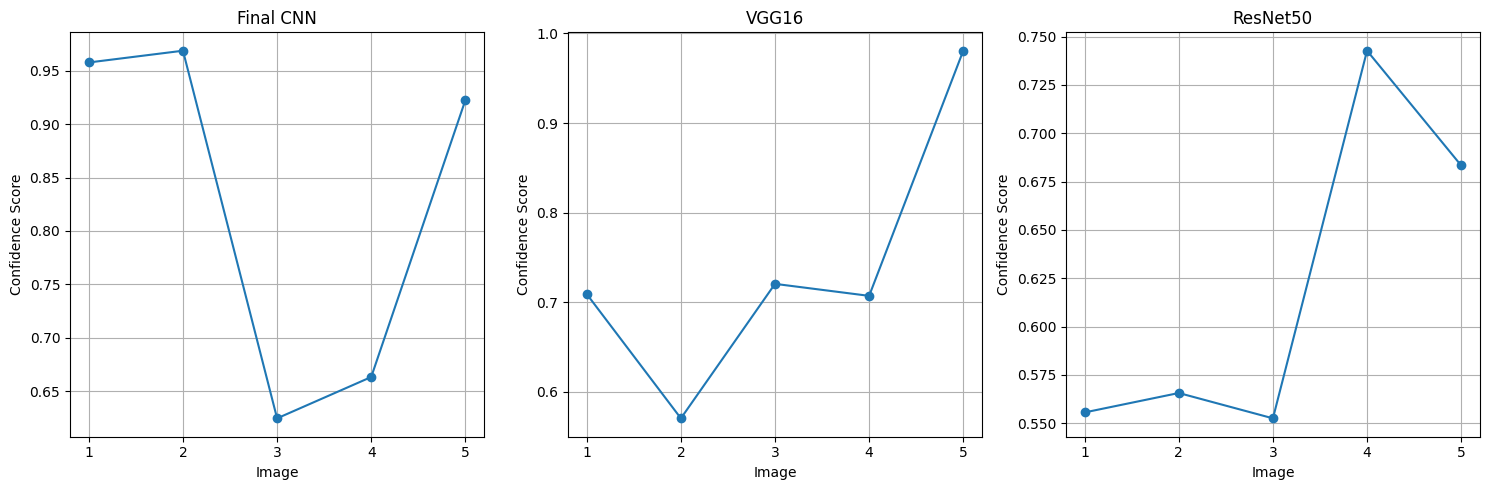

In [ ]:
def plot_confidence_scores(models_to_evaluate, selected_images):
    """Plots confidence scores for multiple models side-by-side."""
    num_images = len(selected_images)
    num_models = len(models_to_evaluate)

    fig, axes = plt.subplots(1, num_models, figsize=(15, 5))  # Adjust figsize as needed

    for i, (model_name, model) in enumerate(models_to_evaluate.items()):
        confidence_scores, _ = predict_with_confidence(model, selected_images)
        axes[i].plot(range(1, num_images + 1), confidence_scores, marker='o')
        axes[i].set_xlabel("Image")
        axes[i].set_ylabel("Confidence Score")
        axes[i].set_title(model_name)
        axes[i].set_xticks(range(1, num_images + 1))  # Ensure x-axis ticks match image numbers
        axes[i].grid(True)


    plt.tight_layout()
    plt.show()

plot_confidence_scores(models_to_evaluate, selected_images)

In [ ]:
# Define the directory to save the models
model_directory = "/content/drive/MyDrive/saved_models"
# Create the directory if it doesn't exist
os.makedirs(model_directory, exist_ok=True)
# Save the models, adding the .keras extension
final_cnn_model.save(os.path.join(model_directory, "final_cnn_model.keras"))
vgg16_model.save(os.path.join(model_directory, "vgg16_model.keras"))
resnet50_model.save(os.path.join(model_directory, "resnet50_model.keras"))

print("Models saved successfully!")

# Define the path to the saved models
model_directory = "/content/drive/MyDrive/saved_models"  # Same as above
# Load the models, adding the .keras extension
loaded_final_cnn_model = tf.keras.models.load_model(os.path.join(model_directory, "final_cnn_model.keras"))
loaded_vgg16_model = tf.keras.models.load_model(os.path.join(model_directory, "vgg16_model.keras"))
loaded_resnet50_model = tf.keras.models.load_model(os.path.join(model_directory, "resnet50_model.keras"))


print("Models loaded successfully!")

Models saved successfully!
Models loaded successfully!


In [ ]:
# For final_cnn_model:
predictions_final_cnn = loaded_final_cnn_model.predict(X_test_rus)
predicted_classes_final_cnn = np.argmax(predictions_final_cnn, axis=1)

# For vgg16_model:
predictions_vgg16 = loaded_vgg16_model.predict(X_test_rus)
predicted_classes_vgg16 = np.argmax(predictions_vgg16, axis=1)

# For resnet50_model:
predictions_resnet50 = loaded_resnet50_model.predict(X_test_rus)
predicted_classes_resnet50 = np.argmax(predictions_resnet50, axis=1)

# Print or further process the predictions
print("Predictions from final_cnn_model:", predicted_classes_final_cnn)
print("Predictions from vgg16_model:", predicted_classes_vgg16)
print("Predictions from resnet50_model:", predicted_classes_resnet50)

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step
Predictions from final_cnn_model: [0 0 1 ... 1 1 1]
Predictions from vgg16_model: [0 1 1 ... 1 1 1]
Predictions from resnet50_model: [0 1 0 ... 1 0 1]


Saving 0_batch_1_sample_290.png to 0_batch_1_sample_290.png
User uploaded file "0_batch_1_sample_290.png" with length 5478 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction for 0_batch_1_sample_290.png:
Confidence: 0.8432
Class: 1


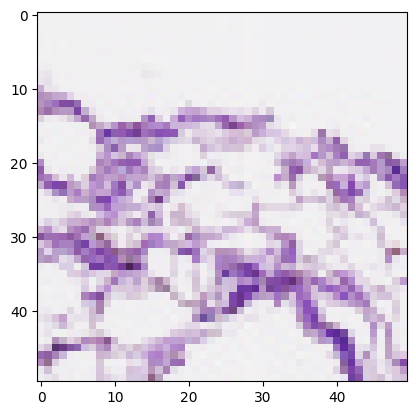

In [ ]:
# prompt: use uploaded = files.upload() to upload image and pridict it , show image as well

from google.colab import files
import matplotlib.pyplot as plt
import cv2
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Assuming the uploaded file is an image
  try:
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
    img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_CUBIC) # Resize the image
    img = np.expand_dims(img, axis=0) # Add batch dimension for prediction
    img = img / 255.0 # Normalize the image


    # Predict with the best model (replace 'best_model' with your actual best model)
    if best_model == "Final CNN":
      confidence_scores, predicted_classes = predict_with_confidence(final_cnn_model, img)
    elif best_model == "VGG16":
      confidence_scores, predicted_classes = predict_with_confidence(vgg16_model, img)
    elif best_model == "ResNet50":
      confidence_scores, predicted_classes = predict_with_confidence(resnet50_model, img)
    else:
      print(f"Error: Best model '{best_model}' not found or not trained.")
      continue


    print(f"Prediction for {fn}:")
    print(f"Confidence: {confidence_scores[0]:.4f}")
    print(f"Class: {predicted_classes[0]}")
    plt.imshow(cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB))
    plt.show()
  except Exception as e:
    print(f"Error processing file {fn}: {e}")